In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig = sig[sig.SR == 2]

bg = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg['is_signal'] = False
# bg = bg[bg.SR == 2]

In [3]:
train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                              'Zcand_mass', 'chisq']])

train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [4]:
# Normalize training features
X = pd.concat([sig[train_feats_raw], bg[train_feats_raw]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

In [5]:
# Load per-background models
models_dir = 'models/background_id_models/'

background_classifiers = {'ZZ': 1, 'Zjets': 2, 'WZ': 1, 'ttZ': 0, 'other': 1}

for bc_name in background_classifiers:
    bc_index = background_classifiers[bc_name]
    
    classifier = keras.models.load_model((models_dir + 'classifier_' + bc_name 
                                          + '_train_feat_test_' + str(bc_index)))
    sig['classifier_' + bc_name + '_score'] = classifier.predict(sig[train_feat_sets[bc_index]], 
                                                                    batch_size=10000)
    bg['classifier_' + bc_name + '_score'] = classifier.predict(bg[train_feat_sets[bc_index]], 
                                                                   batch_size=10000)

2022-01-31 04:47:56.259290: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-31 04:47:56.260971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-31 04:47:56.261009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-31 04:47:56.261025: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-31 04:47:56.261034: I tensorflow/stream_executor/plat

In [12]:
# Cut to 4l-DF signal region
bg = bg[bg.SR == 0.5]
sig = sig[sig.SR == 0.5]

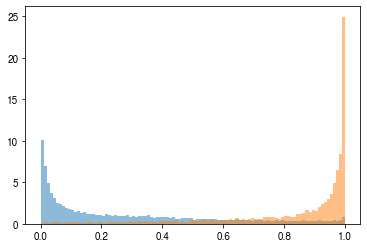

In [13]:
_, b, _ = plt.hist(bg.classifier_ZZ_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_ZZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

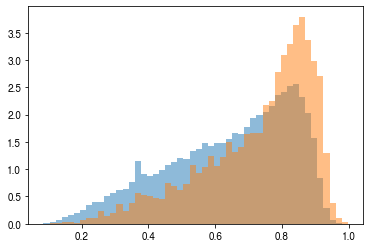

In [18]:
_, b, _ = plt.hist(bg.classifier_Zjets_score, bins=50, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_Zjets_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

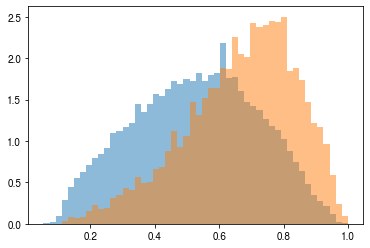

In [21]:
_, b, _ = plt.hist(bg.classifier_WZ_score, bins=50, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_WZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

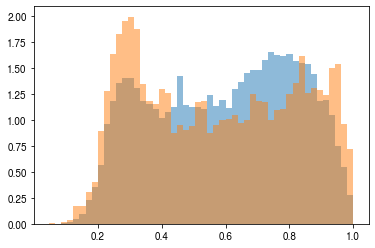

In [20]:
_, b, _ = plt.hist(bg.classifier_ttZ_score, bins=50, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_ttZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

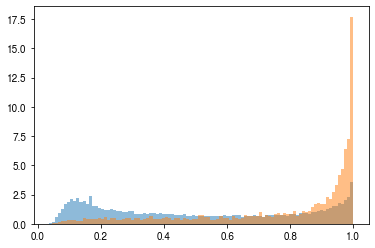

In [22]:
_, b, _ = plt.hist(bg.classifier_other_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_other_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

# Train model

First we want to figure out the signal/background ratio

In [23]:
def region_sig(s, b):
    if s == 0:
        return 0
    return np.sqrt(2 * ((s + b) * np.log(1 + s / b) - s))

n_bg = sum(bg.wgt)
n_sig = sum(sig.wgt)

print('There are', n_bg, 'background events')
print('There are', n_sig, 'signal events')
print('')
print('S/B =', n_sig/n_bg)
print('Starting significance is', region_sig(n_sig, n_bg), 'sigma')
print('Corresponds to', np.sqrt(2.0) * region_sig(n_sig, n_bg), 'sigma')

There are 349.2467328850826 background events
There are 5.889352412916353 signal events

S/B = 0.016863013618667714
Starting significance is 0.3142588982252419 sigma
Corresponds to 0.4444291959665633 sigma


In [24]:
bg['abs_wgt'] = np.abs(bg.wgt)
sig['abs_wgt'] = np.abs(sig.wgt)

In [26]:
bg_classifier_score_feats = ['classifier_' + bc + '_score' for bc in background_classifiers]
combined_train_feats_raw = train_feats_raw + bg_classifier_score_feats

combined_train_feat_sets = [combined_train_feats_raw, 
                            [f for f in combined_train_feats_raw if f not in bg_classifier_score_feats],
                            [f for f in combined_train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 
                                                                              'Zlep1_phi', 'Zlep2_phi']],
                            [f for f in combined_train_feats_raw if f not in ['MET', 'METSig']],
                            [f for f in combined_train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                            [f for f in combined_train_feats_raw if f not in ['Njet', 'Nlep']]
                           ]

In [30]:
EPOCHS = 10000
patience = 500
batch_size = 512
num_nodes = 64
dropout = 0.1
learn_rate = 1e-5

for i, train_feats in enumerate(combined_train_feat_sets):
    model_dir = 'models/SR_4l_SF_noZ_models/'
    model_name = 'classifier_train_feat_test_' + str(i)
    
    print('Running with training features:', train_feats)
    # Save training setup
    with open(model_dir + model_name + '_setup.txt', 'w') as file:
        file.write('Epochs: ' + str(EPOCHS) + '\n')
        file.write('Patience: ' + str(patience) + '\n')
        file.write('Learning rate: ' + str(learn_rate) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n\n')
        file.write('Training features:\n' + '\n'.join(train_feats))
    
    # Generate train and test samples
    sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5, random_state=314)
    bg_train, bg_test = train_test_split(bg[train_feats + ['wgt']], train_size=0.5, random_state=314)

    n_sig = sum(sig_train.wgt)
    n_bg = sum(bg_train.wgt)

    x_train_sig = sig_train[train_feats]
    x_train_bg = bg_train[train_feats]

    x_train = pd.concat([x_train_sig, x_train_bg])
    y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))])
    w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                        (n_sig + n_bg) / n_bg * bg_train['wgt']]))

    n_sig_test = sum(sig_test.wgt)
    n_bg_test = sum(bg_test.wgt)

    x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
    y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
    w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                       (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))
    
    # Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                             validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                             verbose=1, callbacks=[callback], shuffle=True)
    
    # Save model and history
    classifier.save(model_dir + model_name)
    with open(model_dir + model_name + '_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT', 'classifier_ZZ_score', 'classifier_Zjets_score', 'classifier_WZ_score', 'classifier_ttZ_score', 'classifier_other_score']
Epoch 1/10000
233/233 [==============================] - 2s 7ms/step - loss: 0.0020 - accuracy: 0.3654 - val_loss: 0.0021 - val_accuracy: 0.3392
Epoch 2/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0020 - accuracy: 0.4397 - val_loss: 0.0020 - val_accuracy: 0.5072
Epoch 3/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.4939 - val_loss: 0.0020 - val_accuracy: 0.6292
Epoch 4/1000

233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7617 - val_loss: 0.0011 - val_accuracy: 0.7781
Epoch 110/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7637 - val_loss: 0.0011 - val_accuracy: 0.7730
Epoch 111/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7630 - val_loss: 0.0011 - val_accuracy: 0.7709
Epoch 112/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7603 - val_loss: 0.0011 - val_accuracy: 0.7731
Epoch 113/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7617 - val_loss: 0.0011 - val_accuracy: 0.7717
Epoch 114/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7634 - val_loss: 0.0011 - val_accuracy: 0.7705
Epoch 115/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7577 - val_loss: 0.0011 - val_accu

Epoch 165/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7702 - val_loss: 0.0011 - val_accuracy: 0.7837
Epoch 166/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7708 - val_loss: 0.0011 - val_accuracy: 0.7841
Epoch 167/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7720 - val_loss: 0.0011 - val_accuracy: 0.7855
Epoch 168/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7759 - val_loss: 0.0011 - val_accuracy: 0.7812
Epoch 169/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7674 - val_loss: 0.0011 - val_accuracy: 0.7833
Epoch 170/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7714 - val_loss: 0.0011 - val_accuracy: 0.7823
Epoch 171/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7711 - val_loss: 0

Epoch 221/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7751 - val_loss: 0.0011 - val_accuracy: 0.7875
Epoch 222/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7749 - val_loss: 0.0011 - val_accuracy: 0.7878
Epoch 223/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7762 - val_loss: 0.0011 - val_accuracy: 0.7895
Epoch 224/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7772 - val_loss: 0.0011 - val_accuracy: 0.7891
Epoch 225/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7778 - val_loss: 0.0011 - val_accuracy: 0.7878
Epoch 226/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7776 - val_loss: 0.0011 - val_accuracy: 0.7857
Epoch 227/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7765 - val_loss: 0

Epoch 277/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7750 - val_loss: 0.0011 - val_accuracy: 0.7895
Epoch 278/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7795 - val_loss: 0.0011 - val_accuracy: 0.7886
Epoch 279/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7783 - val_loss: 0.0011 - val_accuracy: 0.7913
Epoch 280/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7847 - val_loss: 0.0011 - val_accuracy: 0.7894
Epoch 281/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7798 - val_loss: 0.0011 - val_accuracy: 0.7920
Epoch 282/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7813 - val_loss: 0.0011 - val_accuracy: 0.7903
Epoch 283/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7794 - val_loss: 0

Epoch 333/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7814 - val_loss: 0.0011 - val_accuracy: 0.7952
Epoch 334/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7850 - val_loss: 0.0011 - val_accuracy: 0.7940
Epoch 335/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7844 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 336/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7853 - val_loss: 0.0011 - val_accuracy: 0.7939
Epoch 337/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7839 - val_loss: 0.0011 - val_accuracy: 0.7907
Epoch 338/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7816 - val_loss: 0.0011 - val_accuracy: 0.7928
Epoch 339/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7861 - val_loss: 0

Epoch 389/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7858 - val_loss: 0.0011 - val_accuracy: 0.7971
Epoch 390/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7893 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 391/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7859 - val_loss: 0.0011 - val_accuracy: 0.7967
Epoch 392/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7855 - val_loss: 0.0011 - val_accuracy: 0.7972
Epoch 393/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7856 - val_loss: 0.0011 - val_accuracy: 0.7970
Epoch 394/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7857 - val_loss: 0.0011 - val_accuracy: 0.7960
Epoch 395/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7875 - val_loss: 0

Epoch 445/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7891 - val_loss: 0.0011 - val_accuracy: 0.7987
Epoch 446/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7875 - val_loss: 0.0011 - val_accuracy: 0.8014
Epoch 447/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7886 - val_loss: 0.0011 - val_accuracy: 0.8007
Epoch 448/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7926 - val_loss: 0.0011 - val_accuracy: 0.8006
Epoch 449/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7889 - val_loss: 0.0011 - val_accuracy: 0.7994
Epoch 450/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7882 - val_loss: 0.0011 - val_accuracy: 0.7986
Epoch 451/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7902 - val_loss: 0

Epoch 501/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7924 - val_loss: 0.0011 - val_accuracy: 0.8011
Epoch 502/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7912 - val_loss: 0.0011 - val_accuracy: 0.8013
Epoch 503/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7904 - val_loss: 0.0011 - val_accuracy: 0.8007
Epoch 504/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7889 - val_loss: 0.0011 - val_accuracy: 0.8007
Epoch 505/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7913 - val_loss: 0.0011 - val_accuracy: 0.8013
Epoch 506/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7891 - val_loss: 0.0011 - val_accuracy: 0.7997
Epoch 507/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7917 - val_loss: 0

Epoch 557/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7908 - val_loss: 0.0011 - val_accuracy: 0.8017
Epoch 558/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7900 - val_loss: 0.0011 - val_accuracy: 0.8028
Epoch 559/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7919 - val_loss: 0.0011 - val_accuracy: 0.8015
Epoch 560/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7907 - val_loss: 0.0011 - val_accuracy: 0.8021
Epoch 561/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7910 - val_loss: 0.0011 - val_accuracy: 0.8052
Epoch 562/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7962 - val_loss: 0.0011 - val_accuracy: 0.8007
Epoch 563/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7873 - val_loss: 0

Epoch 613/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7933 - val_loss: 0.0011 - val_accuracy: 0.8011
Epoch 614/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7887 - val_loss: 0.0011 - val_accuracy: 0.8025
Epoch 615/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7942 - val_loss: 0.0011 - val_accuracy: 0.8028
Epoch 616/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7917 - val_loss: 0.0011 - val_accuracy: 0.8031
Epoch 617/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7915 - val_loss: 0.0011 - val_accuracy: 0.8060
Epoch 618/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7933 - val_loss: 0.0011 - val_accuracy: 0.8031
Epoch 619/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7905 - val_loss: 0

Epoch 669/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7935 - val_loss: 0.0011 - val_accuracy: 0.8033
Epoch 670/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7919 - val_loss: 0.0011 - val_accuracy: 0.8039
Epoch 671/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7927 - val_loss: 0.0011 - val_accuracy: 0.8045
Epoch 672/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7927 - val_loss: 0.0011 - val_accuracy: 0.8014
Epoch 673/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7900 - val_loss: 0.0011 - val_accuracy: 0.8048
Epoch 674/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7968 - val_loss: 0.0011 - val_accuracy: 0.8023
Epoch 675/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7923 - val_loss: 0

Epoch 725/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7909 - val_loss: 0.0011 - val_accuracy: 0.8053
Epoch 726/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7937 - val_loss: 0.0011 - val_accuracy: 0.8027
Epoch 727/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7890 - val_loss: 0.0011 - val_accuracy: 0.8057
Epoch 728/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7932 - val_loss: 0.0011 - val_accuracy: 0.8050
Epoch 729/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7944 - val_loss: 0.0011 - val_accuracy: 0.8041
Epoch 730/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7908 - val_loss: 0.0011 - val_accuracy: 0.8051
Epoch 731/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7931 - val_loss: 0

Epoch 781/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7934 - val_loss: 0.0011 - val_accuracy: 0.8092
Epoch 782/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7997 - val_loss: 0.0011 - val_accuracy: 0.8057
Epoch 783/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.8074
Epoch 784/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7930 - val_loss: 0.0011 - val_accuracy: 0.8053
Epoch 785/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7918 - val_loss: 0.0011 - val_accuracy: 0.8062
Epoch 786/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7937 - val_loss: 0.0011 - val_accuracy: 0.8050
Epoch 787/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7917 - val_loss: 0

Epoch 837/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7936 - val_loss: 0.0011 - val_accuracy: 0.8086
Epoch 838/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7958 - val_loss: 0.0011 - val_accuracy: 0.8066
Epoch 839/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7960 - val_loss: 0.0011 - val_accuracy: 0.8059
Epoch 840/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.8050
Epoch 841/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7954 - val_loss: 0.0011 - val_accuracy: 0.8022
Epoch 842/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7913 - val_loss: 0.0011 - val_accuracy: 0.8073
Epoch 843/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7947 - val_loss: 0

Epoch 893/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7936 - val_loss: 0.0011 - val_accuracy: 0.8080
Epoch 894/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7958 - val_loss: 0.0011 - val_accuracy: 0.8056
Epoch 895/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7946 - val_loss: 0.0011 - val_accuracy: 0.8056
Epoch 896/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7967 - val_loss: 0.0011 - val_accuracy: 0.8052
Epoch 897/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7922 - val_loss: 0.0011 - val_accuracy: 0.8064
Epoch 898/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7930 - val_loss: 0.0011 - val_accuracy: 0.8055
Epoch 899/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7899 - val_loss: 0

Epoch 949/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7970 - val_loss: 0.0011 - val_accuracy: 0.8084
Epoch 950/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7982 - val_loss: 0.0011 - val_accuracy: 0.8086
Epoch 951/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7977 - val_loss: 0.0011 - val_accuracy: 0.8089
Epoch 952/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7957 - val_loss: 0.0011 - val_accuracy: 0.8088
Epoch 953/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7939 - val_loss: 0.0011 - val_accuracy: 0.8091
Epoch 954/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7968 - val_loss: 0.0011 - val_accuracy: 0.8077
Epoch 955/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7919 - val_loss: 0

Epoch 1005/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7959 - val_loss: 0.0011 - val_accuracy: 0.8077
Epoch 1006/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7956 - val_loss: 0.0011 - val_accuracy: 0.8080
Epoch 1007/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7960 - val_loss: 0.0011 - val_accuracy: 0.8071
Epoch 1008/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7946 - val_loss: 0.0011 - val_accuracy: 0.8073
Epoch 1009/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7977 - val_loss: 0.0011 - val_accuracy: 0.8057
Epoch 1010/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7949 - val_loss: 0.0011 - val_accuracy: 0.8093
Epoch 1011/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7958 - val_

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7985 - val_loss: 0.0011 - val_accuracy: 0.8085
Epoch 1116/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9790e-04 - accuracy: 0.7976 - val_loss: 0.0011 - val_accuracy: 0.8109
Epoch 1117/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7959 - val_loss: 0.0011 - val_accuracy: 0.8108
Epoch 1118/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7964 - val_loss: 0.0011 - val_accuracy: 0.8094
Epoch 1119/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7967 - val_loss: 0.0011 - val_accuracy: 0.8081
Epoch 1120/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7963 - val_loss: 0.0011 - val_accuracy: 0.8079
Epoch 1121/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7941 - val_loss: 0.0011 

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7947 - val_loss: 0.0011 - val_accuracy: 0.8120
Epoch 1226/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7988 - val_loss: 0.0011 - val_accuracy: 0.8096
Epoch 1227/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7958 - val_loss: 0.0011 - val_accuracy: 0.8104
Epoch 1228/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8008 - val_loss: 0.0011 - val_accuracy: 0.8098
Epoch 1229/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7957 - val_loss: 0.0011 - val_accuracy: 0.8111
Epoch 1230/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8009 - val_loss: 0.0011 - val_accuracy: 0.8102
Epoch 1231/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7973 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 9.8215e-04 - accuracy: 0.7999 - val_loss: 0.0011 - val_accuracy: 0.8136
Epoch 1336/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8012 - val_loss: 0.0011 - val_accuracy: 0.8114
Epoch 1337/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7968 - val_loss: 0.0011 - val_accuracy: 0.8119
Epoch 1338/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7989 - val_loss: 0.0011 - val_accuracy: 0.8098
Epoch 1339/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7974 - val_loss: 0.0011 - val_accuracy: 0.8108
Epoch 1340/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7965 - val_loss: 0.0011 - val_accuracy: 0.8114
Epoch 1341/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7990 - val_loss: 0.0011 

233/233 [==============================] - 1s 6ms/step - loss: 9.7264e-04 - accuracy: 0.8005 - val_loss: 0.0011 - val_accuracy: 0.8113
Epoch 1446/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7997 - val_loss: 0.0011 - val_accuracy: 0.8131
Epoch 1447/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9917e-04 - accuracy: 0.7995 - val_loss: 0.0011 - val_accuracy: 0.8119
Epoch 1448/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7988 - val_loss: 0.0011 - val_accuracy: 0.8126
Epoch 1449/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8005 - val_loss: 0.0011 - val_accuracy: 0.8121
Epoch 1450/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7994 - val_loss: 0.0011 - val_accuracy: 0.8110
Epoch 1451/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7985 - val_loss: 0.0

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7984 - val_loss: 0.0011 - val_accuracy: 0.8111
Epoch 1556/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7996 - val_loss: 0.0011 - val_accuracy: 0.8127
Epoch 1557/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7994 - val_loss: 0.0011 - val_accuracy: 0.8112
Epoch 1558/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7992 - val_loss: 0.0011 - val_accuracy: 0.8141
Epoch 1559/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.8487e-04 - accuracy: 0.8024 - val_loss: 0.0011 - val_accuracy: 0.8118
Epoch 1560/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7976 - val_loss: 0.0011 - val_accuracy: 0.8140
Epoch 1561/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7979 - val_loss: 0.0011 

2022-01-31 05:42:34.761448: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/SR_4l_SF_noZ_models/classifier_train_feat_test_0/assets
Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/10000
233/233 [==============================] - 2s 7ms/step - loss: 0.0021 - accuracy: 0.0738 - val_loss: 0.0021 - val_accuracy: 0.0619
Epoch 2/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.1090 - val_loss: 0.0021 - val_accuracy: 0.0963
Epoch 3/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0021 - accuracy: 0.1620 - val_loss: 0.0021 - val_accuracy: 0.1550
Epoch 4/10000
233/233 [=============

233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6709 - val_loss: 0.0017 - val_accuracy: 0.6942
Epoch 110/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6662 - val_loss: 0.0017 - val_accuracy: 0.7002
Epoch 111/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6725 - val_loss: 0.0017 - val_accuracy: 0.6943
Epoch 112/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6663 - val_loss: 0.0017 - val_accuracy: 0.6946
Epoch 113/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6722 - val_loss: 0.0017 - val_accuracy: 0.6955
Epoch 114/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6697 - val_loss: 0.0017 - val_accuracy: 0.7020
Epoch 115/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6721 - val_loss: 0.0017 - val_accu

Epoch 165/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6707 - val_loss: 0.0016 - val_accuracy: 0.6858
Epoch 166/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.6741 - val_loss: 0.0016 - val_accuracy: 0.6909
Epoch 167/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6740 - val_loss: 0.0016 - val_accuracy: 0.6884
Epoch 168/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6737 - val_loss: 0.0016 - val_accuracy: 0.6860
Epoch 169/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6727 - val_loss: 0.0016 - val_accuracy: 0.6874
Epoch 170/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6734 - val_loss: 0.0016 - val_accuracy: 0.6925
Epoch 171/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6733 - val_loss: 0

Epoch 221/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6641 - val_loss: 0.0016 - val_accuracy: 0.6859
Epoch 222/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6746 - val_loss: 0.0016 - val_accuracy: 0.6808
Epoch 223/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6678 - val_loss: 0.0016 - val_accuracy: 0.6848
Epoch 224/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6740 - val_loss: 0.0015 - val_accuracy: 0.6772
Epoch 225/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6619 - val_loss: 0.0015 - val_accuracy: 0.6780
Epoch 226/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6652 - val_loss: 0.0015 - val_accuracy: 0.6793
Epoch 227/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6656 - val_loss: 0

Epoch 277/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6661 - val_loss: 0.0015 - val_accuracy: 0.6804
Epoch 278/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6672 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 279/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6639 - val_loss: 0.0015 - val_accuracy: 0.6761
Epoch 280/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6699 - val_loss: 0.0015 - val_accuracy: 0.6735
Epoch 281/10000
233/233 [==============================] - 1s 5ms/step - loss: 0.0016 - accuracy: 0.6632 - val_loss: 0.0015 - val_accuracy: 0.6739
Epoch 282/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.6627 - val_loss: 0.0015 - val_accuracy: 0.6804
Epoch 283/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6702 - val_loss: 0

Epoch 333/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6630 - val_loss: 0.0015 - val_accuracy: 0.6752
Epoch 334/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6713 - val_loss: 0.0015 - val_accuracy: 0.6732
Epoch 335/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6653 - val_loss: 0.0015 - val_accuracy: 0.6802
Epoch 336/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6637 - val_loss: 0.0015 - val_accuracy: 0.6804
Epoch 337/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6691 - val_loss: 0.0015 - val_accuracy: 0.6756
Epoch 338/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6656 - val_loss: 0.0015 - val_accuracy: 0.6764
Epoch 339/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6622 - val_loss: 0

Epoch 389/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6700 - val_loss: 0.0014 - val_accuracy: 0.6829
Epoch 390/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6738 - val_loss: 0.0014 - val_accuracy: 0.6779
Epoch 391/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6655 - val_loss: 0.0014 - val_accuracy: 0.6872
Epoch 392/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6695 - val_loss: 0.0014 - val_accuracy: 0.6862
Epoch 393/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6673 - val_loss: 0.0014 - val_accuracy: 0.6824
Epoch 394/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6687 - val_loss: 0.0014 - val_accuracy: 0.6846
Epoch 395/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6692 - val_loss: 0

Epoch 445/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6766 - val_loss: 0.0014 - val_accuracy: 0.6933
Epoch 446/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6771 - val_loss: 0.0014 - val_accuracy: 0.6931
Epoch 447/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6772 - val_loss: 0.0014 - val_accuracy: 0.6959
Epoch 448/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6856 - val_loss: 0.0014 - val_accuracy: 0.6845
Epoch 449/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6708 - val_loss: 0.0014 - val_accuracy: 0.6920
Epoch 450/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6742 - val_loss: 0.0014 - val_accuracy: 0.6907
Epoch 451/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.6761 - val_loss: 0

Epoch 501/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6851 - val_loss: 0.0014 - val_accuracy: 0.7027
Epoch 502/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6881 - val_loss: 0.0014 - val_accuracy: 0.7056
Epoch 503/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6855 - val_loss: 0.0014 - val_accuracy: 0.7076
Epoch 504/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6957 - val_loss: 0.0014 - val_accuracy: 0.7077
Epoch 505/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6884 - val_loss: 0.0014 - val_accuracy: 0.7074
Epoch 506/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6842 - val_loss: 0.0014 - val_accuracy: 0.7074
Epoch 507/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6904 - val_loss: 0

Epoch 557/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.7028 - val_loss: 0.0013 - val_accuracy: 0.7163
Epoch 558/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.6990 - val_loss: 0.0013 - val_accuracy: 0.7121
Epoch 559/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6932 - val_loss: 0.0013 - val_accuracy: 0.7137
Epoch 560/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6988 - val_loss: 0.0013 - val_accuracy: 0.7177
Epoch 561/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.7001 - val_loss: 0.0013 - val_accuracy: 0.7155
Epoch 562/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.6982 - val_loss: 0.0013 - val_accuracy: 0.7206
Epoch 563/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.7043 - val_loss: 0

Epoch 613/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0013 - accuracy: 0.7069 - val_loss: 0.0013 - val_accuracy: 0.7270
Epoch 614/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0013 - accuracy: 0.7084 - val_loss: 0.0013 - val_accuracy: 0.7293
Epoch 615/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7077 - val_loss: 0.0013 - val_accuracy: 0.7267
Epoch 616/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.7094 - val_loss: 0.0013 - val_accuracy: 0.7333
Epoch 617/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.7082 - val_loss: 0.0013 - val_accuracy: 0.7318
Epoch 618/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7089 - val_loss: 0.0013 - val_accuracy: 0.7283
Epoch 619/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7095 - val_loss: 0

Epoch 669/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7202 - val_loss: 0.0013 - val_accuracy: 0.7422
Epoch 670/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7237 - val_loss: 0.0013 - val_accuracy: 0.7392
Epoch 671/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7154 - val_loss: 0.0013 - val_accuracy: 0.7497
Epoch 672/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7267 - val_loss: 0.0013 - val_accuracy: 0.7373
Epoch 673/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7147 - val_loss: 0.0013 - val_accuracy: 0.7389
Epoch 674/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0013 - accuracy: 0.7183 - val_loss: 0.0013 - val_accuracy: 0.7376
Epoch 675/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.7166 - val_loss: 0

Epoch 725/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7278 - val_loss: 0.0013 - val_accuracy: 0.7542
Epoch 726/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7343 - val_loss: 0.0013 - val_accuracy: 0.7505
Epoch 727/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7230 - val_loss: 0.0013 - val_accuracy: 0.7538
Epoch 728/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7342 - val_loss: 0.0013 - val_accuracy: 0.7502
Epoch 729/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7281 - val_loss: 0.0013 - val_accuracy: 0.7490
Epoch 730/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7270 - val_loss: 0.0013 - val_accuracy: 0.7491
Epoch 731/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7352 - val_loss: 0

Epoch 781/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7388 - val_loss: 0.0012 - val_accuracy: 0.7534
Epoch 782/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7334 - val_loss: 0.0012 - val_accuracy: 0.7564
Epoch 783/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7358 - val_loss: 0.0012 - val_accuracy: 0.7646
Epoch 784/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7387 - val_loss: 0.0012 - val_accuracy: 0.7610
Epoch 785/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7333 - val_loss: 0.0012 - val_accuracy: 0.7650
Epoch 786/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7476 - val_loss: 0.0012 - val_accuracy: 0.7544
Epoch 787/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0012 - accuracy: 0.7357 - val_loss: 0

Epoch 837/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7451 - val_loss: 0.0012 - val_accuracy: 0.7735
Epoch 838/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7465 - val_loss: 0.0012 - val_accuracy: 0.7727
Epoch 839/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7472 - val_loss: 0.0012 - val_accuracy: 0.7723
Epoch 840/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7467 - val_loss: 0.0012 - val_accuracy: 0.7742
Epoch 841/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0012 - accuracy: 0.7485 - val_loss: 0.0012 - val_accuracy: 0.7714
Epoch 842/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7449 - val_loss: 0.0012 - val_accuracy: 0.7707
Epoch 843/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7405 - val_loss: 0

Epoch 893/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7552 - val_loss: 0.0012 - val_accuracy: 0.7754
Epoch 894/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7541 - val_loss: 0.0012 - val_accuracy: 0.7697
Epoch 895/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7531 - val_loss: 0.0012 - val_accuracy: 0.7735
Epoch 896/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7511 - val_loss: 0.0012 - val_accuracy: 0.7737
Epoch 897/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7517 - val_loss: 0.0012 - val_accuracy: 0.7766
Epoch 898/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7487 - val_loss: 0.0012 - val_accuracy: 0.7752
Epoch 899/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7511 - val_loss: 0

Epoch 949/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7524 - val_loss: 0.0012 - val_accuracy: 0.7920
Epoch 950/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7657 - val_loss: 0.0012 - val_accuracy: 0.7787
Epoch 951/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7552 - val_loss: 0.0012 - val_accuracy: 0.7801
Epoch 952/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7560 - val_loss: 0.0012 - val_accuracy: 0.7780
Epoch 953/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7560 - val_loss: 0.0012 - val_accuracy: 0.7824
Epoch 954/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7597 - val_loss: 0.0012 - val_accuracy: 0.7797
Epoch 955/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7561 - val_loss: 0

Epoch 1005/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7605 - val_loss: 0.0012 - val_accuracy: 0.7872
Epoch 1006/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7620 - val_loss: 0.0012 - val_accuracy: 0.7858
Epoch 1007/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7681 - val_loss: 0.0012 - val_accuracy: 0.7832
Epoch 1008/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7645 - val_loss: 0.0012 - val_accuracy: 0.7753
Epoch 1009/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7557 - val_loss: 0.0012 - val_accuracy: 0.7879
Epoch 1010/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7678 - val_loss: 0.0012 - val_accuracy: 0.7823
Epoch 1011/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7582 - val_

233/233 [==============================] - 2s 6ms/step - loss: 0.0012 - accuracy: 0.7709 - val_loss: 0.0012 - val_accuracy: 0.7912
Epoch 1116/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7667 - val_loss: 0.0012 - val_accuracy: 0.7893
Epoch 1117/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7673 - val_loss: 0.0012 - val_accuracy: 0.7945
Epoch 1118/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7772 - val_loss: 0.0012 - val_accuracy: 0.7841
Epoch 1119/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7695 - val_loss: 0.0012 - val_accuracy: 0.7862
Epoch 1120/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7673 - val_loss: 0.0012 - val_accuracy: 0.7909
Epoch 1121/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7694 - val_loss: 0.0012 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7704 - val_loss: 0.0011 - val_accuracy: 0.7958
Epoch 1226/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7780 - val_loss: 0.0011 - val_accuracy: 0.7881
Epoch 1227/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7707 - val_loss: 0.0011 - val_accuracy: 0.7930
Epoch 1228/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7748 - val_loss: 0.0011 - val_accuracy: 0.7935
Epoch 1229/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7758 - val_loss: 0.0011 - val_accuracy: 0.7909
Epoch 1230/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7761 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 1231/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7763 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7824 - val_loss: 0.0011 - val_accuracy: 0.7964
Epoch 1336/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7787 - val_loss: 0.0011 - val_accuracy: 0.7982
Epoch 1337/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.7790 - val_loss: 0.0011 - val_accuracy: 0.7941
Epoch 1338/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7745 - val_loss: 0.0011 - val_accuracy: 0.8030
Epoch 1339/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7839 - val_loss: 0.0011 - val_accuracy: 0.7930
Epoch 1340/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7792 - val_loss: 0.0011 - val_accuracy: 0.7950
Epoch 1341/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7777 - val_loss: 0.0011 - va

233/233 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.7800 - val_loss: 0.0011 - val_accuracy: 0.7991
Epoch 1446/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7849 - val_loss: 0.0011 - val_accuracy: 0.7887
Epoch 1447/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7818 - val_loss: 0.0011 - val_accuracy: 0.7970
Epoch 1448/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7798 - val_loss: 0.0011 - val_accuracy: 0.8008
Epoch 1449/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7888 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 1450/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7789 - val_loss: 0.0011 - val_accuracy: 0.7967
Epoch 1451/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7816 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7848 - val_loss: 0.0011 - val_accuracy: 0.7996
Epoch 1556/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7823 - val_loss: 0.0011 - val_accuracy: 0.7996
Epoch 1557/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7879 - val_loss: 0.0011 - val_accuracy: 0.8007
Epoch 1558/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7863 - val_loss: 0.0011 - val_accuracy: 0.7957
Epoch 1559/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7869 - val_loss: 0.0011 - val_accuracy: 0.7943
Epoch 1560/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.7791 - val_loss: 0.0011 - val_accuracy: 0.8017
Epoch 1561/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7859 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7890 - val_loss: 0.0011 - val_accuracy: 0.7916
Epoch 1666/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7804 - val_loss: 0.0011 - val_accuracy: 0.7982
Epoch 1667/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7865 - val_loss: 0.0011 - val_accuracy: 0.7969
Epoch 1668/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7872 - val_loss: 0.0011 - val_accuracy: 0.7923
Epoch 1669/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.7794 - val_loss: 0.0011 - val_accuracy: 0.8005
Epoch 1670/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7888 - val_loss: 0.0011 - val_accuracy: 0.7986
Epoch 1671/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7890 - val_loss: 0.0011 - va

233/233 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.7893 - val_loss: 0.0011 - val_accuracy: 0.7961
Epoch 1776/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7968
Epoch 1777/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7869 - val_loss: 0.0011 - val_accuracy: 0.8034
Epoch 1778/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7900 - val_loss: 0.0011 - val_accuracy: 0.7986
Epoch 1779/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7920 - val_loss: 0.0011 - val_accuracy: 0.7967
Epoch 1780/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0010 - accuracy: 0.7891 - val_loss: 0.0011 - val_accuracy: 0.7961
Epoch 1781/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.7843 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7926 - val_loss: 0.0011 - val_accuracy: 0.7964
Epoch 1886/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7854 - val_loss: 0.0011 - val_accuracy: 0.8011
Epoch 1887/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7909 - val_loss: 0.0011 - val_accuracy: 0.8032
Epoch 1888/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7901 - val_loss: 0.0011 - val_accuracy: 0.8041
Epoch 1889/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7931 - val_loss: 0.0011 - val_accuracy: 0.8013
Epoch 1890/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7899 - val_loss: 0.0011 - val_accuracy: 0.7999
Epoch 1891/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7860 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7943 - val_loss: 0.0011 - val_accuracy: 0.7979
Epoch 1996/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9808e-04 - accuracy: 0.7934 - val_loss: 0.0011 - val_accuracy: 0.8042
Epoch 1997/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7951 - val_loss: 0.0011 - val_accuracy: 0.7928
Epoch 1998/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7926 - val_loss: 0.0011 - val_accuracy: 0.7880
Epoch 1999/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7835 - val_loss: 0.0011 - val_accuracy: 0.8043
Epoch 2000/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7955 - val_loss: 0.0011 - val_accuracy: 0.8032
Epoch 2001/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7922 - val_loss: 0.0011 

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7925 - val_loss: 0.0011 - val_accuracy: 0.8027
Epoch 2106/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7921 - val_loss: 0.0011 - val_accuracy: 0.7992
Epoch 2107/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7915 - val_loss: 0.0011 - val_accuracy: 0.8000
Epoch 2108/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7941 - val_loss: 0.0011 - val_accuracy: 0.7952
Epoch 2109/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7905 - val_loss: 0.0011 - val_accuracy: 0.7935
Epoch 2110/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7873 - val_loss: 0.0011 - val_accuracy: 0.8048
Epoch 2111/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7941 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7924 - val_loss: 0.0011 - val_accuracy: 0.8012
Epoch 2216/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7947 - val_loss: 0.0011 - val_accuracy: 0.8029
Epoch 2217/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7921 - val_loss: 0.0011 - val_accuracy: 0.8020
Epoch 2218/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9889e-04 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.7992
Epoch 2219/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9287e-04 - accuracy: 0.7921 - val_loss: 0.0011 - val_accuracy: 0.8045
Epoch 2220/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9516e-04 - accuracy: 0.7986 - val_loss: 0.0011 - val_accuracy: 0.7993
Epoch 2221/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.8166e-04 - accuracy: 0.7951 - val_l

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7913 - val_loss: 0.0011 - val_accuracy: 0.7992
Epoch 2326/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7898 - val_loss: 0.0011 - val_accuracy: 0.8042
Epoch 2327/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7940 - val_loss: 0.0011 - val_accuracy: 0.8091
Epoch 2328/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8011 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 2329/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9498e-04 - accuracy: 0.7947 - val_loss: 0.0011 - val_accuracy: 0.7942
Epoch 2330/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9761e-04 - accuracy: 0.7896 - val_loss: 0.0011 - val_accuracy: 0.7954
Epoch 2331/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.6197e-04 - accuracy: 0.7903 - val_loss:

Epoch 2380/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8010 - val_loss: 0.0011 - val_accuracy: 0.8007
Epoch 2381/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.8688e-04 - accuracy: 0.7948 - val_loss: 0.0011 - val_accuracy: 0.8066
Epoch 2382/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7990 - val_loss: 0.0011 - val_accuracy: 0.8029
Epoch 2383/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7928 - val_loss: 0.0011 - val_accuracy: 0.8002
Epoch 2384/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7896 - val_loss: 0.0011 - val_accuracy: 0.8059
Epoch 2385/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9435e-04 - accuracy: 0.7969 - val_loss: 0.0011 - val_accuracy: 0.7986
Epoch 2386/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.798

Epoch 2435/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.7348e-04 - accuracy: 0.7979 - val_loss: 0.0011 - val_accuracy: 0.7966
Epoch 2436/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7879 - val_loss: 0.0011 - val_accuracy: 0.7976
Epoch 2437/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7896 - val_loss: 0.0011 - val_accuracy: 0.8045
Epoch 2438/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9020e-04 - accuracy: 0.7953 - val_loss: 0.0011 - val_accuracy: 0.8036
Epoch 2439/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.8429e-04 - accuracy: 0.7960 - val_loss: 0.0011 - val_accuracy: 0.8034
Epoch 2440/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7943 - val_loss: 0.0011 - val_accuracy: 0.7975
Epoch 2441/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.8452e-04 - accurac

233/233 [==============================] - 1s 6ms/step - loss: 9.6869e-04 - accuracy: 0.7943 - val_loss: 0.0011 - val_accuracy: 0.8014
Epoch 2544/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9928e-04 - accuracy: 0.7919 - val_loss: 0.0011 - val_accuracy: 0.8036
Epoch 2545/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7943 - val_loss: 0.0011 - val_accuracy: 0.8085
Epoch 2546/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.8935e-04 - accuracy: 0.8008 - val_loss: 0.0011 - val_accuracy: 0.7975
Epoch 2547/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9921e-04 - accuracy: 0.7942 - val_loss: 0.0011 - val_accuracy: 0.7980
Epoch 2548/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9601e-04 - accuracy: 0.7941 - val_loss: 0.0011 - val_accuracy: 0.8004
Epoch 2549/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7962 - v

233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.6988 - val_loss: 0.0013 - val_accuracy: 0.6995
Epoch 24/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.7000 - val_loss: 0.0013 - val_accuracy: 0.7033
Epoch 25/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.7019 - val_loss: 0.0013 - val_accuracy: 0.7056
Epoch 26/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.7040 - val_loss: 0.0012 - val_accuracy: 0.7106
Epoch 27/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.7101 - val_loss: 0.0012 - val_accuracy: 0.7078
Epoch 28/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.7064 - val_loss: 0.0012 - val_accuracy: 0.7125
Epoch 29/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7084 - val_loss: 0.0012 - val_accuracy: 

Epoch 135/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7620 - val_loss: 0.0011 - val_accuracy: 0.7661
Epoch 136/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7628 - val_loss: 0.0011 - val_accuracy: 0.7659
Epoch 137/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7609 - val_loss: 0.0011 - val_accuracy: 0.7692
Epoch 138/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7650 - val_loss: 0.0011 - val_accuracy: 0.7678
Epoch 139/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7618 - val_loss: 0.0011 - val_accuracy: 0.7673
Epoch 140/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7606 - val_loss: 0.0011 - val_accuracy: 0.7682
Epoch 141/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7655 - val_loss: 0

Epoch 191/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7711 - val_loss: 0.0011 - val_accuracy: 0.7757
Epoch 192/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7702 - val_loss: 0.0011 - val_accuracy: 0.7761
Epoch 193/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7729 - val_loss: 0.0011 - val_accuracy: 0.7753
Epoch 194/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7734 - val_loss: 0.0011 - val_accuracy: 0.7747
Epoch 195/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7717 - val_loss: 0.0011 - val_accuracy: 0.7757
Epoch 196/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7725 - val_loss: 0.0011 - val_accuracy: 0.7744
Epoch 197/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7701 - val_loss: 0

Epoch 247/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7787 - val_loss: 0.0011 - val_accuracy: 0.7818
Epoch 248/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7766 - val_loss: 0.0011 - val_accuracy: 0.7810
Epoch 249/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7756 - val_loss: 0.0011 - val_accuracy: 0.7796
Epoch 250/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7749 - val_loss: 0.0011 - val_accuracy: 0.7783
Epoch 251/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7758 - val_loss: 0.0011 - val_accuracy: 0.7793
Epoch 252/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7769 - val_loss: 0.0011 - val_accuracy: 0.7810
Epoch 253/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7741 - val_loss: 0

Epoch 303/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7803 - val_loss: 0.0011 - val_accuracy: 0.7810
Epoch 304/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7769 - val_loss: 0.0011 - val_accuracy: 0.7834
Epoch 305/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7804 - val_loss: 0.0011 - val_accuracy: 0.7853
Epoch 306/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7827 - val_loss: 0.0011 - val_accuracy: 0.7838
Epoch 307/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7818 - val_loss: 0.0011 - val_accuracy: 0.7840
Epoch 308/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7816 - val_loss: 0.0011 - val_accuracy: 0.7844
Epoch 309/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7800 - val_loss: 0

Epoch 359/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7866 - val_loss: 0.0011 - val_accuracy: 0.7861
Epoch 360/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7817 - val_loss: 0.0011 - val_accuracy: 0.7863
Epoch 361/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7822 - val_loss: 0.0011 - val_accuracy: 0.7886
Epoch 362/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7860 - val_loss: 0.0011 - val_accuracy: 0.7891
Epoch 363/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7861 - val_loss: 0.0011 - val_accuracy: 0.7883
Epoch 364/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7846 - val_loss: 0.0011 - val_accuracy: 0.7874
Epoch 365/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7860 - val_loss: 0

Epoch 415/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7854 - val_loss: 0.0011 - val_accuracy: 0.7905
Epoch 416/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7886 - val_loss: 0.0011 - val_accuracy: 0.7913
Epoch 417/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7863 - val_loss: 0.0011 - val_accuracy: 0.7881
Epoch 418/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7860 - val_loss: 0.0011 - val_accuracy: 0.7884
Epoch 419/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7866 - val_loss: 0.0011 - val_accuracy: 0.7882
Epoch 420/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7857 - val_loss: 0.0011 - val_accuracy: 0.7910
Epoch 421/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7899 - val_loss: 0

Epoch 471/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7876 - val_loss: 0.0011 - val_accuracy: 0.7915
Epoch 472/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7880 - val_loss: 0.0011 - val_accuracy: 0.7903
Epoch 473/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7922
Epoch 474/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7868 - val_loss: 0.0011 - val_accuracy: 0.7947
Epoch 475/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7899 - val_loss: 0.0011 - val_accuracy: 0.7925
Epoch 476/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7888 - val_loss: 0.0011 - val_accuracy: 0.7911
Epoch 477/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7861 - val_loss: 0

Epoch 527/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7907 - val_loss: 0.0011 - val_accuracy: 0.7939
Epoch 528/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7895 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 529/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7916 - val_loss: 0.0011 - val_accuracy: 0.7939
Epoch 530/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7898 - val_loss: 0.0011 - val_accuracy: 0.7939
Epoch 531/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7901 - val_loss: 0.0011 - val_accuracy: 0.7957
Epoch 532/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7903 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 533/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7896 - val_loss: 0

Epoch 583/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7952 - val_loss: 0.0011 - val_accuracy: 0.7958
Epoch 584/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7923 - val_loss: 0.0011 - val_accuracy: 0.7928
Epoch 585/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7891 - val_loss: 0.0011 - val_accuracy: 0.7962
Epoch 586/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7946 - val_loss: 0.0011 - val_accuracy: 0.7963
Epoch 587/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7914 - val_loss: 0.0011 - val_accuracy: 0.7982
Epoch 588/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7931 - val_loss: 0.0011 - val_accuracy: 0.7970
Epoch 589/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7939 - val_loss: 0

Epoch 639/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7949 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 640/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.7986
Epoch 641/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7943 - val_loss: 0.0011 - val_accuracy: 0.7990
Epoch 642/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7956 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 643/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7957 - val_loss: 0.0011 - val_accuracy: 0.7987
Epoch 644/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7956 - val_loss: 0.0011 - val_accuracy: 0.7952
Epoch 645/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7928 - val_loss: 0

Epoch 695/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.8001
Epoch 696/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7955 - val_loss: 0.0011 - val_accuracy: 0.8024
Epoch 697/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7951 - val_loss: 0.0011 - val_accuracy: 0.8017
Epoch 698/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8010 - val_loss: 0.0011 - val_accuracy: 0.7999
Epoch 699/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7967 - val_loss: 0.0011 - val_accuracy: 0.7982
Epoch 700/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7953 - val_loss: 0.0011 - val_accuracy: 0.7973
Epoch 701/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7948 - val_loss: 0

Epoch 751/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7999 - val_loss: 0.0011 - val_accuracy: 0.7987
Epoch 752/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7948 - val_loss: 0.0011 - val_accuracy: 0.8005
Epoch 753/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7955 - val_loss: 0.0011 - val_accuracy: 0.8006
Epoch 754/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7966 - val_loss: 0.0011 - val_accuracy: 0.8006
Epoch 755/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7962 - val_loss: 0.0011 - val_accuracy: 0.8017
Epoch 756/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7960 - val_loss: 0.0011 - val_accuracy: 0.8009
Epoch 757/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7943 - val_loss: 0

Epoch 807/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7969 - val_loss: 0.0011 - val_accuracy: 0.8033
Epoch 808/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7976 - val_loss: 0.0011 - val_accuracy: 0.8023
Epoch 809/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7988 - val_loss: 0.0011 - val_accuracy: 0.8016
Epoch 810/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8001 - val_loss: 0.0011 - val_accuracy: 0.8015
Epoch 811/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7965 - val_loss: 0.0011 - val_accuracy: 0.8030
Epoch 812/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7993 - val_loss: 0.0011 - val_accuracy: 0.8035
Epoch 813/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7978 - val_loss: 0

Epoch 863/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7965 - val_loss: 0.0011 - val_accuracy: 0.8035
Epoch 864/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7995 - val_loss: 0.0011 - val_accuracy: 0.8024
Epoch 865/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7972 - val_loss: 0.0011 - val_accuracy: 0.8025
Epoch 866/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7994 - val_loss: 0.0011 - val_accuracy: 0.8016
Epoch 867/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7984 - val_loss: 0.0011 - val_accuracy: 0.8025
Epoch 868/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7981 - val_loss: 0.0011 - val_accuracy: 0.8017
Epoch 869/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7988 - val_loss: 0

Epoch 919/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7994 - val_loss: 0.0011 - val_accuracy: 0.8044
Epoch 920/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8002 - val_loss: 0.0011 - val_accuracy: 0.8057
Epoch 921/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7996 - val_loss: 0.0011 - val_accuracy: 0.8042
Epoch 922/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8011 - val_loss: 0.0011 - val_accuracy: 0.8039
Epoch 923/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8005 - val_loss: 0.0011 - val_accuracy: 0.8031
Epoch 924/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8000 - val_loss: 0.0011 - val_accuracy: 0.8052
Epoch 925/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8001 - val_loss: 0

Epoch 975/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8002 - val_loss: 0.0011 - val_accuracy: 0.8048
Epoch 976/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7992 - val_loss: 0.0011 - val_accuracy: 0.8055
Epoch 977/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8024 - val_loss: 0.0011 - val_accuracy: 0.8047
Epoch 978/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8001 - val_loss: 0.0011 - val_accuracy: 0.8054
Epoch 979/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8017 - val_loss: 0.0011 - val_accuracy: 0.8051
Epoch 980/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8005 - val_loss: 0.0011 - val_accuracy: 0.8047
Epoch 981/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8011 - val_loss: 0

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8012 - val_loss: 0.0011 - val_accuracy: 0.8076
Epoch 1086/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8049 - val_loss: 0.0011 - val_accuracy: 0.8051
Epoch 1087/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7982 - val_loss: 0.0011 - val_accuracy: 0.8068
Epoch 1088/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8026 - val_loss: 0.0011 - val_accuracy: 0.8065
Epoch 1089/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7991 - val_loss: 0.0011 - val_accuracy: 0.8076
Epoch 1090/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8029 - val_loss: 0.0011 - val_accuracy: 0.8078
Epoch 1091/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8018 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8040 - val_loss: 0.0011 - val_accuracy: 0.8115
Epoch 1196/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8044 - val_loss: 0.0011 - val_accuracy: 0.8089
Epoch 1197/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8053 - val_loss: 0.0011 - val_accuracy: 0.8076
Epoch 1198/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8056 - val_loss: 0.0011 - val_accuracy: 0.8075
Epoch 1199/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8023 - val_loss: 0.0011 - val_accuracy: 0.8092
Epoch 1200/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8058 - val_loss: 0.0011 - val_accuracy: 0.8078
Epoch 1201/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8018 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8061 - val_loss: 0.0011 - val_accuracy: 0.8131
Epoch 1306/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8058 - val_loss: 0.0011 - val_accuracy: 0.8127
Epoch 1307/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8082 - val_loss: 0.0011 - val_accuracy: 0.8118
Epoch 1308/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8058 - val_loss: 0.0011 - val_accuracy: 0.8116
Epoch 1309/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8049 - val_loss: 0.0011 - val_accuracy: 0.8113
Epoch 1310/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8058 - val_loss: 0.0011 - val_accuracy: 0.8107
Epoch 1311/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8030 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8078 - val_loss: 0.0011 - val_accuracy: 0.8125
Epoch 1416/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8072 - val_loss: 0.0011 - val_accuracy: 0.8120
Epoch 1417/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8068 - val_loss: 0.0011 - val_accuracy: 0.8110
Epoch 1418/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8057 - val_loss: 0.0011 - val_accuracy: 0.8132
Epoch 1419/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8060 - val_loss: 0.0011 - val_accuracy: 0.8129
Epoch 1420/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8074 - val_loss: 0.0011 - val_accuracy: 0.8128
Epoch 1421/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8093 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8065 - val_loss: 0.0011 - val_accuracy: 0.8120
Epoch 1526/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8075 - val_loss: 0.0011 - val_accuracy: 0.8133
Epoch 1527/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8067 - val_loss: 0.0011 - val_accuracy: 0.8132
Epoch 1528/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8079 - val_loss: 0.0011 - val_accuracy: 0.8115
Epoch 1529/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8059 - val_loss: 0.0011 - val_accuracy: 0.8136
Epoch 1530/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8074 - val_loss: 0.0011 - val_accuracy: 0.8127
Epoch 1531/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8068 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8088 - val_loss: 0.0011 - val_accuracy: 0.8129
Epoch 1636/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.9590e-04 - accuracy: 0.8075 - val_loss: 0.0011 - val_accuracy: 0.8133
Epoch 1637/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8079 - val_loss: 0.0011 - val_accuracy: 0.8150
Epoch 1638/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8067 - val_loss: 0.0011 - val_accuracy: 0.8160
Epoch 1639/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8090 - val_loss: 0.0011 - val_accuracy: 0.8152
Epoch 1640/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8068 - val_loss: 0.0011 - val_accuracy: 0.8159
Epoch 1641/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8076 - val_loss: 0.0011 

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8067 - val_loss: 0.0011 - val_accuracy: 0.8138
Epoch 1746/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8084 - val_loss: 0.0011 - val_accuracy: 0.8121
Epoch 1747/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8070 - val_loss: 0.0011 - val_accuracy: 0.8128
Epoch 1748/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8091 - val_loss: 0.0011 - val_accuracy: 0.8124
Epoch 1749/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8066 - val_loss: 0.0011 - val_accuracy: 0.8138
Epoch 1750/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8077 - val_loss: 0.0011 - val_accuracy: 0.8145
Epoch 1751/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8066 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7186 - val_loss: 0.0012 - val_accuracy: 0.7165
Epoch 31/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7175 - val_loss: 0.0012 - val_accuracy: 0.7183
Epoch 32/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7229 - val_loss: 0.0012 - val_accuracy: 0.7200
Epoch 33/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7211 - val_loss: 0.0012 - val_accuracy: 0.7212
Epoch 34/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7251 - val_loss: 0.0012 - val_accuracy: 0.7252
Epoch 35/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7268 - val_loss: 0.0012 - val_accuracy: 0.7213
Epoch 36/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7265 - val_loss: 0.0012 - val_accuracy: 

Epoch 142/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7636 - val_loss: 0.0011 - val_accuracy: 0.7666
Epoch 143/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7652 - val_loss: 0.0011 - val_accuracy: 0.7647
Epoch 144/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7643 - val_loss: 0.0011 - val_accuracy: 0.7652
Epoch 145/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7666 - val_loss: 0.0011 - val_accuracy: 0.7686
Epoch 146/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7658 - val_loss: 0.0011 - val_accuracy: 0.7689
Epoch 147/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7666 - val_loss: 0.0011 - val_accuracy: 0.7666
Epoch 148/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7653 - val_loss: 0

Epoch 198/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7721 - val_loss: 0.0011 - val_accuracy: 0.7766
Epoch 199/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7709 - val_loss: 0.0011 - val_accuracy: 0.7748
Epoch 200/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7719 - val_loss: 0.0011 - val_accuracy: 0.7730
Epoch 201/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7675 - val_loss: 0.0011 - val_accuracy: 0.7738
Epoch 202/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7713 - val_loss: 0.0011 - val_accuracy: 0.7763
Epoch 203/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7730 - val_loss: 0.0011 - val_accuracy: 0.7756
Epoch 204/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7710 - val_loss: 0

Epoch 254/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7737 - val_loss: 0.0011 - val_accuracy: 0.7774
Epoch 255/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7747 - val_loss: 0.0011 - val_accuracy: 0.7776
Epoch 256/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7767 - val_loss: 0.0011 - val_accuracy: 0.7776
Epoch 257/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7772 - val_loss: 0.0011 - val_accuracy: 0.7767
Epoch 258/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7725 - val_loss: 0.0011 - val_accuracy: 0.7772
Epoch 259/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7763 - val_loss: 0.0011 - val_accuracy: 0.7795
Epoch 260/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7782 - val_loss: 0

Epoch 310/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7788 - val_loss: 0.0011 - val_accuracy: 0.7830
Epoch 311/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7790 - val_loss: 0.0011 - val_accuracy: 0.7816
Epoch 312/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7809 - val_loss: 0.0011 - val_accuracy: 0.7808
Epoch 313/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7751 - val_loss: 0.0011 - val_accuracy: 0.7859
Epoch 314/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7801 - val_loss: 0.0011 - val_accuracy: 0.7845
Epoch 315/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7816 - val_loss: 0.0011 - val_accuracy: 0.7857
Epoch 316/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7806 - val_loss: 0

Epoch 366/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7836 - val_loss: 0.0011 - val_accuracy: 0.7863
Epoch 367/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7851 - val_loss: 0.0011 - val_accuracy: 0.7856
Epoch 368/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7851 - val_loss: 0.0011 - val_accuracy: 0.7869
Epoch 369/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7855 - val_loss: 0.0011 - val_accuracy: 0.7887
Epoch 370/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7844 - val_loss: 0.0011 - val_accuracy: 0.7869
Epoch 371/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7861 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 372/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7796 - val_loss: 0

Epoch 422/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7846 - val_loss: 0.0011 - val_accuracy: 0.7899
Epoch 423/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7866 - val_loss: 0.0011 - val_accuracy: 0.7917
Epoch 424/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7911
Epoch 425/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7895 - val_loss: 0.0011 - val_accuracy: 0.7901
Epoch 426/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7915
Epoch 427/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7881 - val_loss: 0.0011 - val_accuracy: 0.7882
Epoch 428/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7855 - val_loss: 0

Epoch 478/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7920 - val_loss: 0.0011 - val_accuracy: 0.7927
Epoch 479/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7878 - val_loss: 0.0011 - val_accuracy: 0.7916
Epoch 480/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7896 - val_loss: 0.0011 - val_accuracy: 0.7923
Epoch 481/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7921
Epoch 482/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7886 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 483/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7902 - val_loss: 0.0011 - val_accuracy: 0.7931
Epoch 484/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7874 - val_loss: 0

Epoch 534/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7887 - val_loss: 0.0011 - val_accuracy: 0.7916
Epoch 535/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7895 - val_loss: 0.0011 - val_accuracy: 0.7944
Epoch 536/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7915 - val_loss: 0.0011 - val_accuracy: 0.7944
Epoch 537/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7907 - val_loss: 0.0011 - val_accuracy: 0.7924
Epoch 538/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7906 - val_loss: 0.0011 - val_accuracy: 0.7939
Epoch 539/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7898 - val_loss: 0.0011 - val_accuracy: 0.7943
Epoch 540/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7900 - val_loss: 0

Epoch 590/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7922 - val_loss: 0.0011 - val_accuracy: 0.7938
Epoch 591/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7897 - val_loss: 0.0011 - val_accuracy: 0.7961
Epoch 592/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7894 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 593/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7947 - val_loss: 0.0011 - val_accuracy: 0.7957
Epoch 594/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7945 - val_loss: 0.0011 - val_accuracy: 0.7928
Epoch 595/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7898 - val_loss: 0.0011 - val_accuracy: 0.7954
Epoch 596/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7926 - val_loss: 0

Epoch 646/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7922 - val_loss: 0.0011 - val_accuracy: 0.7949
Epoch 647/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7903 - val_loss: 0.0011 - val_accuracy: 0.7971
Epoch 648/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7939 - val_loss: 0.0011 - val_accuracy: 0.7938
Epoch 649/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7957 - val_loss: 0.0011 - val_accuracy: 0.7957
Epoch 650/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7948 - val_loss: 0.0011 - val_accuracy: 0.7952
Epoch 651/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7911 - val_loss: 0.0011 - val_accuracy: 0.7951
Epoch 652/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7899 - val_loss: 0

Epoch 702/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7927 - val_loss: 0.0011 - val_accuracy: 0.7985
Epoch 703/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.7962
Epoch 704/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7930 - val_loss: 0.0011 - val_accuracy: 0.7971
Epoch 705/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7955 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 706/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7901 - val_loss: 0.0011 - val_accuracy: 0.7972
Epoch 707/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7926 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 708/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7932 - val_loss: 0

Epoch 758/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7929 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 759/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7933 - val_loss: 0.0011 - val_accuracy: 0.7945
Epoch 760/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7932 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 761/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7931 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 762/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7912 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 763/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7944 - val_loss: 0.0011 - val_accuracy: 0.7958
Epoch 764/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7921 - val_loss: 0

Epoch 814/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7931 - val_loss: 0.0011 - val_accuracy: 0.7962
Epoch 815/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7936 - val_loss: 0.0011 - val_accuracy: 0.7965
Epoch 816/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7924 - val_loss: 0.0011 - val_accuracy: 0.7964
Epoch 817/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7921 - val_loss: 0.0011 - val_accuracy: 0.7984
Epoch 818/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7955 - val_loss: 0.0011 - val_accuracy: 0.7980
Epoch 819/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7955 - val_loss: 0.0011 - val_accuracy: 0.7982
Epoch 820/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7963 - val_loss: 0

Epoch 870/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.7976
Epoch 871/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7960 - val_loss: 0.0011 - val_accuracy: 0.8000
Epoch 872/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7984 - val_loss: 0.0011 - val_accuracy: 0.7999
Epoch 873/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7967 - val_loss: 0.0011 - val_accuracy: 0.7995
Epoch 874/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7964 - val_loss: 0.0011 - val_accuracy: 0.7982
Epoch 875/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.7989
Epoch 876/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7959 - val_loss: 0

Epoch 926/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7961 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 927/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7951 - val_loss: 0.0011 - val_accuracy: 0.7970
Epoch 928/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7935 - val_loss: 0.0011 - val_accuracy: 0.7966
Epoch 929/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7951 - val_loss: 0.0011 - val_accuracy: 0.7960
Epoch 930/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7926 - val_loss: 0.0011 - val_accuracy: 0.7952
Epoch 931/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7911 - val_loss: 0.0011 - val_accuracy: 0.7983
Epoch 932/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7942 - val_loss: 0

Epoch 982/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7957 - val_loss: 0.0011 - val_accuracy: 0.7992
Epoch 983/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7939 - val_loss: 0.0011 - val_accuracy: 0.8000
Epoch 984/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7947 - val_loss: 0.0011 - val_accuracy: 0.7992
Epoch 985/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7982 - val_loss: 0.0011 - val_accuracy: 0.7987
Epoch 986/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7958 - val_loss: 0.0011 - val_accuracy: 0.7975
Epoch 987/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7931 - val_loss: 0.0011 - val_accuracy: 0.8008
Epoch 988/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7973 - val_loss: 0

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7980 - val_loss: 0.0011 - val_accuracy: 0.8007
Epoch 1093/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7972 - val_loss: 0.0011 - val_accuracy: 0.7999
Epoch 1094/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7965 - val_loss: 0.0011 - val_accuracy: 0.7998
Epoch 1095/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7966 - val_loss: 0.0011 - val_accuracy: 0.7993
Epoch 1096/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7963 - val_loss: 0.0011 - val_accuracy: 0.7980
Epoch 1097/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7936 - val_loss: 0.0011 - val_accuracy: 0.8006
Epoch 1098/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7991 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7991 - val_loss: 0.0011 - val_accuracy: 0.8021
Epoch 1203/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7983 - val_loss: 0.0011 - val_accuracy: 0.8029
Epoch 1204/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7978 - val_loss: 0.0011 - val_accuracy: 0.8001
Epoch 1205/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7956 - val_loss: 0.0011 - val_accuracy: 0.7990
Epoch 1206/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7970 - val_loss: 0.0011 - val_accuracy: 0.8000
Epoch 1207/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7979 - val_loss: 0.0011 - val_accuracy: 0.7985
Epoch 1208/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7953 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7999 - val_loss: 0.0011 - val_accuracy: 0.7985
Epoch 1313/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7975 - val_loss: 0.0011 - val_accuracy: 0.8002
Epoch 1314/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7960 - val_loss: 0.0011 - val_accuracy: 0.8002
Epoch 1315/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7972 - val_loss: 0.0011 - val_accuracy: 0.8018
Epoch 1316/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7975 - val_loss: 0.0011 - val_accuracy: 0.8029
Epoch 1317/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.8000 - val_loss: 0.0011 - val_accuracy: 0.8011
Epoch 1318/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7991 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7985 - val_loss: 0.0011 - val_accuracy: 0.8028
Epoch 1423/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8030 - val_loss: 0.0011 - val_accuracy: 0.8006
Epoch 1424/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7977 - val_loss: 0.0011 - val_accuracy: 0.8019
Epoch 1425/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7989 - val_loss: 0.0011 - val_accuracy: 0.8025
Epoch 1426/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7989 - val_loss: 0.0011 - val_accuracy: 0.8002
Epoch 1427/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7983 - val_loss: 0.0011 - val_accuracy: 0.8023
Epoch 1428/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8002 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 9.6403e-04 - accuracy: 0.8007 - val_loss: 0.0011 - val_accuracy: 0.8030
Epoch 1533/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7980 - val_loss: 0.0011 - val_accuracy: 0.8044
Epoch 1534/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7997 - val_loss: 0.0011 - val_accuracy: 0.8043
Epoch 1535/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8014 - val_loss: 0.0011 - val_accuracy: 0.8043
Epoch 1536/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8004 - val_loss: 0.0011 - val_accuracy: 0.8037
Epoch 1537/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7988 - val_loss: 0.0011 - val_accuracy: 0.8034
Epoch 1538/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8004 - val_loss: 0.0011 

233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7347 - val_loss: 0.0011 - val_accuracy: 0.7358
Epoch 62/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7330 - val_loss: 0.0011 - val_accuracy: 0.7381
Epoch 63/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7332 - val_loss: 0.0011 - val_accuracy: 0.7404
Epoch 64/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7361 - val_loss: 0.0011 - val_accuracy: 0.7370
Epoch 65/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7314 - val_loss: 0.0011 - val_accuracy: 0.7397
Epoch 66/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7373 - val_loss: 0.0011 - val_accuracy: 0.7403
Epoch 67/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.7360 - val_loss: 0.0011 - val_accuracy: 

233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7582 - val_loss: 0.0011 - val_accuracy: 0.7605
Epoch 118/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7546 - val_loss: 0.0011 - val_accuracy: 0.7592
Epoch 119/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7570 - val_loss: 0.0011 - val_accuracy: 0.7622
Epoch 120/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7578 - val_loss: 0.0011 - val_accuracy: 0.7644
Epoch 121/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7607 - val_loss: 0.0011 - val_accuracy: 0.7625
Epoch 122/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7585 - val_loss: 0.0011 - val_accuracy: 0.7613
Epoch 123/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7599 - val_loss: 0.0011 - val_accu

Epoch 173/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7705 - val_loss: 0.0011 - val_accuracy: 0.7766
Epoch 174/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7692 - val_loss: 0.0011 - val_accuracy: 0.7757
Epoch 175/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7684 - val_loss: 0.0011 - val_accuracy: 0.7768
Epoch 176/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7694 - val_loss: 0.0011 - val_accuracy: 0.7760
Epoch 177/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7705 - val_loss: 0.0011 - val_accuracy: 0.7794
Epoch 178/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7741 - val_loss: 0.0011 - val_accuracy: 0.7805
Epoch 179/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7760 - val_loss: 0

Epoch 229/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7788 - val_loss: 0.0011 - val_accuracy: 0.7864
Epoch 230/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7803 - val_loss: 0.0011 - val_accuracy: 0.7835
Epoch 231/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7765 - val_loss: 0.0011 - val_accuracy: 0.7858
Epoch 232/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7779 - val_loss: 0.0011 - val_accuracy: 0.7872
Epoch 233/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7804 - val_loss: 0.0011 - val_accuracy: 0.7838
Epoch 234/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7750 - val_loss: 0.0011 - val_accuracy: 0.7843
Epoch 235/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7803 - val_loss: 0

Epoch 285/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7871 - val_loss: 0.0011 - val_accuracy: 0.7856
Epoch 286/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7794 - val_loss: 0.0011 - val_accuracy: 0.7883
Epoch 287/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7851 - val_loss: 0.0011 - val_accuracy: 0.7877
Epoch 288/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7817 - val_loss: 0.0011 - val_accuracy: 0.7910
Epoch 289/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7822 - val_loss: 0.0011 - val_accuracy: 0.7887
Epoch 290/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7807 - val_loss: 0.0011 - val_accuracy: 0.7872
Epoch 291/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7828 - val_loss: 0

Epoch 341/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7853 - val_loss: 0.0011 - val_accuracy: 0.7902
Epoch 342/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7843 - val_loss: 0.0011 - val_accuracy: 0.7903
Epoch 343/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7793 - val_loss: 0.0011 - val_accuracy: 0.7918
Epoch 344/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7869 - val_loss: 0.0011 - val_accuracy: 0.7926
Epoch 345/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7874 - val_loss: 0.0011 - val_accuracy: 0.7912
Epoch 346/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7844 - val_loss: 0.0011 - val_accuracy: 0.7919
Epoch 347/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7863 - val_loss: 0

Epoch 397/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7830 - val_loss: 0.0011 - val_accuracy: 0.7915
Epoch 398/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7874 - val_loss: 0.0011 - val_accuracy: 0.7944
Epoch 399/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7844 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 400/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7870 - val_loss: 0.0011 - val_accuracy: 0.7924
Epoch 401/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7852 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 402/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7882 - val_loss: 0.0011 - val_accuracy: 0.7917
Epoch 403/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7847 - val_loss: 0

Epoch 453/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7894 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 454/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7857 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 455/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7887 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 456/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7860 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 457/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7934
Epoch 458/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7885 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 459/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7864 - val_loss: 0

Epoch 509/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7900 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 510/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7942
Epoch 511/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7915 - val_loss: 0.0011 - val_accuracy: 0.7921
Epoch 512/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7844 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 513/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7861 - val_loss: 0.0011 - val_accuracy: 0.7935
Epoch 514/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7852 - val_loss: 0.0011 - val_accuracy: 0.7945
Epoch 515/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7916 - val_loss: 0

Epoch 565/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7912 - val_loss: 0.0011 - val_accuracy: 0.7945
Epoch 566/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7948
Epoch 567/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7890 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 568/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7895 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 569/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7897 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 570/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7891 - val_loss: 0.0011 - val_accuracy: 0.7939
Epoch 571/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7922 - val_loss: 0

Epoch 621/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7908 - val_loss: 0.0011 - val_accuracy: 0.7926
Epoch 622/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7895 - val_loss: 0.0011 - val_accuracy: 0.7948
Epoch 623/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7939 - val_loss: 0.0011 - val_accuracy: 0.7947
Epoch 624/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7892 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 625/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7937
Epoch 626/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7891 - val_loss: 0.0011 - val_accuracy: 0.7961
Epoch 627/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7884 - val_loss: 0

Epoch 677/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7896 - val_loss: 0.0011 - val_accuracy: 0.7951
Epoch 678/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7922 - val_loss: 0.0011 - val_accuracy: 0.7942
Epoch 679/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7901 - val_loss: 0.0011 - val_accuracy: 0.7938
Epoch 680/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7878 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 681/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7904 - val_loss: 0.0011 - val_accuracy: 0.7941
Epoch 682/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7899 - val_loss: 0.0011 - val_accuracy: 0.7948
Epoch 683/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7901 - val_loss: 0

Epoch 733/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7924 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 734/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7888 - val_loss: 0.0011 - val_accuracy: 0.7958
Epoch 735/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7920 - val_loss: 0.0011 - val_accuracy: 0.7965
Epoch 736/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7942 - val_loss: 0.0011 - val_accuracy: 0.7940
Epoch 737/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7893 - val_loss: 0.0011 - val_accuracy: 0.7949
Epoch 738/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7924 - val_loss: 0.0011 - val_accuracy: 0.7956
Epoch 739/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7941 - val_loss: 0

Epoch 789/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7934 - val_loss: 0.0011 - val_accuracy: 0.7936
Epoch 790/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7893 - val_loss: 0.0011 - val_accuracy: 0.7941
Epoch 791/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7864 - val_loss: 0.0011 - val_accuracy: 0.7969
Epoch 792/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7954 - val_loss: 0.0011 - val_accuracy: 0.7952
Epoch 793/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7929 - val_loss: 0.0011 - val_accuracy: 0.7965
Epoch 794/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7907 - val_loss: 0.0011 - val_accuracy: 0.7964
Epoch 795/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7927 - val_loss: 0

Epoch 845/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7934 - val_loss: 0.0011 - val_accuracy: 0.7944
Epoch 846/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7898 - val_loss: 0.0011 - val_accuracy: 0.7974
Epoch 847/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7934 - val_loss: 0.0011 - val_accuracy: 0.7963
Epoch 848/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7923 - val_loss: 0.0011 - val_accuracy: 0.7959
Epoch 849/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7905 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 850/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7910 - val_loss: 0.0011 - val_accuracy: 0.7953
Epoch 851/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7906 - val_loss: 0

Epoch 901/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7910 - val_loss: 0.0011 - val_accuracy: 0.7974
Epoch 902/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.7967
Epoch 903/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7906 - val_loss: 0.0011 - val_accuracy: 0.7984
Epoch 904/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7974 - val_loss: 0.0011 - val_accuracy: 0.7961
Epoch 905/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7922 - val_loss: 0.0011 - val_accuracy: 0.7975
Epoch 906/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7895 - val_loss: 0.0011 - val_accuracy: 0.7963
Epoch 907/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7949 - val_loss: 0

Epoch 957/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7948 - val_loss: 0.0011 - val_accuracy: 0.7964
Epoch 958/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7909 - val_loss: 0.0011 - val_accuracy: 0.7971
Epoch 959/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7935 - val_loss: 0.0011 - val_accuracy: 0.7948
Epoch 960/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7930 - val_loss: 0.0011 - val_accuracy: 0.7957
Epoch 961/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7892 - val_loss: 0.0011 - val_accuracy: 0.7969
Epoch 962/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7899 - val_loss: 0.0011 - val_accuracy: 0.7979
Epoch 963/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7928 - val_loss: 0

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7963 - val_loss: 0.0011 - val_accuracy: 0.7986
Epoch 1068/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7946 - val_loss: 0.0011 - val_accuracy: 0.7991
Epoch 1069/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7944 - val_loss: 0.0011 - val_accuracy: 0.7984
Epoch 1070/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7945 - val_loss: 0.0011 - val_accuracy: 0.7999
Epoch 1071/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7964 - val_loss: 0.0011 - val_accuracy: 0.8007
Epoch 1072/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7954 - val_loss: 0.0011 - val_accuracy: 0.7997
Epoch 1073/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7953 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7957 - val_loss: 0.0011 - val_accuracy: 0.7993
Epoch 1178/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7964 - val_loss: 0.0011 - val_accuracy: 0.8010
Epoch 1179/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7982 - val_loss: 0.0011 - val_accuracy: 0.7992
Epoch 1180/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.8005
Epoch 1181/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7948 - val_loss: 0.0011 - val_accuracy: 0.7991
Epoch 1182/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7970 - val_loss: 0.0011 - val_accuracy: 0.8003
Epoch 1183/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7975 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7970 - val_loss: 0.0011 - val_accuracy: 0.8013
Epoch 1288/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7978 - val_loss: 0.0011 - val_accuracy: 0.8010
Epoch 1289/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7947 - val_loss: 0.0011 - val_accuracy: 0.8043
Epoch 1290/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7983 - val_loss: 0.0011 - val_accuracy: 0.8026
Epoch 1291/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7961 - val_loss: 0.0011 - val_accuracy: 0.8015
Epoch 1292/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7949 - val_loss: 0.0011 - val_accuracy: 0.8015
Epoch 1293/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7970 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0020 - accuracy: 0.3814 - val_loss: 0.0020 - val_accuracy: 0.4221
Epoch 6/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0019 - accuracy: 0.4430 - val_loss: 0.0020 - val_accuracy: 0.4862
Epoch 7/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0019 - accuracy: 0.5020 - val_loss: 0.0019 - val_accuracy: 0.5392
Epoch 8/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0019 - accuracy: 0.5345 - val_loss: 0.0019 - val_accuracy: 0.5835
Epoch 9/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.5813 - val_loss: 0.0018 - val_accuracy: 0.6066
Epoch 10/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0019 - accuracy: 0.6036 - val_loss: 0.0018 - val_accuracy: 0.6446
Epoch 11/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.6411 - val_loss: 0.0017 - val_accuracy: 0.65

233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7616 - val_loss: 0.0011 - val_accuracy: 0.7629
Epoch 118/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7630 - val_loss: 0.0011 - val_accuracy: 0.7629
Epoch 119/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7607 - val_loss: 0.0011 - val_accuracy: 0.7615
Epoch 120/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7624 - val_loss: 0.0011 - val_accuracy: 0.7574
Epoch 121/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7597 - val_loss: 0.0011 - val_accuracy: 0.7625
Epoch 122/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7620 - val_loss: 0.0011 - val_accuracy: 0.7647
Epoch 123/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7604 - val_loss: 0.0011 - val_accu

Epoch 173/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7690 - val_loss: 0.0011 - val_accuracy: 0.7731
Epoch 174/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7717 - val_loss: 0.0011 - val_accuracy: 0.7722
Epoch 175/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7690 - val_loss: 0.0011 - val_accuracy: 0.7754
Epoch 176/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7722 - val_loss: 0.0011 - val_accuracy: 0.7722
Epoch 177/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7700 - val_loss: 0.0011 - val_accuracy: 0.7734
Epoch 178/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7705 - val_loss: 0.0011 - val_accuracy: 0.7727
Epoch 179/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7713 - val_loss: 0

Epoch 229/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7735 - val_loss: 0.0011 - val_accuracy: 0.7784
Epoch 230/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7771 - val_loss: 0.0011 - val_accuracy: 0.7781
Epoch 231/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7751 - val_loss: 0.0011 - val_accuracy: 0.7779
Epoch 232/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7748 - val_loss: 0.0011 - val_accuracy: 0.7818
Epoch 233/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7784 - val_loss: 0.0011 - val_accuracy: 0.7785
Epoch 234/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7742 - val_loss: 0.0011 - val_accuracy: 0.7770
Epoch 235/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7767 - val_loss: 0

Epoch 285/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7792 - val_loss: 0.0011 - val_accuracy: 0.7843
Epoch 286/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7819 - val_loss: 0.0011 - val_accuracy: 0.7833
Epoch 287/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7783 - val_loss: 0.0011 - val_accuracy: 0.7824
Epoch 288/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7780 - val_loss: 0.0011 - val_accuracy: 0.7835
Epoch 289/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7836 - val_loss: 0.0011 - val_accuracy: 0.7820
Epoch 290/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7783 - val_loss: 0.0011 - val_accuracy: 0.7826
Epoch 291/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7786 - val_loss: 0

Epoch 341/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7822 - val_loss: 0.0011 - val_accuracy: 0.7840
Epoch 342/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7805 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 343/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7814 - val_loss: 0.0011 - val_accuracy: 0.7852
Epoch 344/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7820 - val_loss: 0.0011 - val_accuracy: 0.7838
Epoch 345/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7807 - val_loss: 0.0011 - val_accuracy: 0.7841
Epoch 346/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7842 - val_loss: 0.0011 - val_accuracy: 0.7833
Epoch 347/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7829 - val_loss: 0

Epoch 397/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.7828 - val_loss: 0.0011 - val_accuracy: 0.7902
Epoch 398/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7848 - val_loss: 0.0011 - val_accuracy: 0.7883
Epoch 399/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7865 - val_loss: 0.0011 - val_accuracy: 0.7870
Epoch 400/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7851 - val_loss: 0.0011 - val_accuracy: 0.7873
Epoch 401/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7831 - val_loss: 0.0011 - val_accuracy: 0.7849
Epoch 402/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7832 - val_loss: 0.0011 - val_accuracy: 0.7885
Epoch 403/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7891 - val_loss: 0

Epoch 453/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7904 - val_loss: 0.0011 - val_accuracy: 0.7900
Epoch 454/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7849 - val_loss: 0.0011 - val_accuracy: 0.7899
Epoch 455/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7850 - val_loss: 0.0011 - val_accuracy: 0.7916
Epoch 456/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7875 - val_loss: 0.0011 - val_accuracy: 0.7896
Epoch 457/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7843 - val_loss: 0.0011 - val_accuracy: 0.7911
Epoch 458/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7881 - val_loss: 0.0011 - val_accuracy: 0.7897
Epoch 459/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7850 - val_loss: 0

Epoch 509/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7877 - val_loss: 0.0011 - val_accuracy: 0.7927
Epoch 510/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7886 - val_loss: 0.0011 - val_accuracy: 0.7893
Epoch 511/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7907 - val_loss: 0.0011 - val_accuracy: 0.7910
Epoch 512/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7880 - val_loss: 0.0011 - val_accuracy: 0.7927
Epoch 513/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7919 - val_loss: 0.0011 - val_accuracy: 0.7887
Epoch 514/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7839 - val_loss: 0.0011 - val_accuracy: 0.7919
Epoch 515/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7883 - val_loss: 0

Epoch 565/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7869 - val_loss: 0.0011 - val_accuracy: 0.7909
Epoch 566/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7892 - val_loss: 0.0011 - val_accuracy: 0.7908
Epoch 567/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7876 - val_loss: 0.0011 - val_accuracy: 0.7931
Epoch 568/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7891 - val_loss: 0.0011 - val_accuracy: 0.7921
Epoch 569/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7916 - val_loss: 0.0011 - val_accuracy: 0.7919
Epoch 570/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7889 - val_loss: 0.0011 - val_accuracy: 0.7926
Epoch 571/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7888 - val_loss: 0

Epoch 621/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7950 - val_loss: 0.0011 - val_accuracy: 0.7942
Epoch 622/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7904 - val_loss: 0.0011 - val_accuracy: 0.7932
Epoch 623/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7916 - val_loss: 0.0011 - val_accuracy: 0.7944
Epoch 624/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7922 - val_loss: 0.0011 - val_accuracy: 0.7960
Epoch 625/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7935 - val_loss: 0.0011 - val_accuracy: 0.7951
Epoch 626/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7915 - val_loss: 0.0011 - val_accuracy: 0.7954
Epoch 627/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7916 - val_loss: 0

Epoch 677/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7888 - val_loss: 0.0011 - val_accuracy: 0.7958
Epoch 678/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7954 - val_loss: 0.0011 - val_accuracy: 0.7941
Epoch 679/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7916 - val_loss: 0.0011 - val_accuracy: 0.7940
Epoch 680/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7904 - val_loss: 0.0011 - val_accuracy: 0.7945
Epoch 681/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7919 - val_loss: 0.0011 - val_accuracy: 0.7941
Epoch 682/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7900 - val_loss: 0.0011 - val_accuracy: 0.7942
Epoch 683/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7887 - val_loss: 0

Epoch 733/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7928 - val_loss: 0.0011 - val_accuracy: 0.7965
Epoch 734/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7958 - val_loss: 0.0011 - val_accuracy: 0.7951
Epoch 735/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7903 - val_loss: 0.0011 - val_accuracy: 0.7949
Epoch 736/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7924 - val_loss: 0.0011 - val_accuracy: 0.7951
Epoch 737/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7938 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 738/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7932 - val_loss: 0.0011 - val_accuracy: 0.7951
Epoch 739/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7917 - val_loss: 0

Epoch 789/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7896 - val_loss: 0.0011 - val_accuracy: 0.7971
Epoch 790/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7935 - val_loss: 0.0011 - val_accuracy: 0.7952
Epoch 791/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7920 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 792/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7946 - val_loss: 0.0011 - val_accuracy: 0.7962
Epoch 793/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7912 - val_loss: 0.0011 - val_accuracy: 0.7952
Epoch 794/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7949 - val_loss: 0.0011 - val_accuracy: 0.7960
Epoch 795/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7911 - val_loss: 0

Epoch 845/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7919 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 846/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7921 - val_loss: 0.0011 - val_accuracy: 0.7946
Epoch 847/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7926 - val_loss: 0.0011 - val_accuracy: 0.7965
Epoch 848/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7949 - val_loss: 0.0011 - val_accuracy: 0.7937
Epoch 849/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7921 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 850/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7948 - val_loss: 0.0011 - val_accuracy: 0.7964
Epoch 851/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7938 - val_loss: 0

Epoch 901/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7921 - val_loss: 0.0011 - val_accuracy: 0.7976
Epoch 902/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7951 - val_loss: 0.0011 - val_accuracy: 0.7972
Epoch 903/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7965 - val_loss: 0.0011 - val_accuracy: 0.7983
Epoch 904/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7959 - val_loss: 0.0011 - val_accuracy: 0.7971
Epoch 905/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7944 - val_loss: 0.0011 - val_accuracy: 0.7955
Epoch 906/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7936 - val_loss: 0.0011 - val_accuracy: 0.7979
Epoch 907/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7934 - val_loss: 0

Epoch 957/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7935 - val_loss: 0.0011 - val_accuracy: 0.7959
Epoch 958/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7949 - val_loss: 0.0011 - val_accuracy: 0.7993
Epoch 959/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7944 - val_loss: 0.0011 - val_accuracy: 0.7992
Epoch 960/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7949 - val_loss: 0.0011 - val_accuracy: 0.7983
Epoch 961/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7955 - val_loss: 0.0011 - val_accuracy: 0.7977
Epoch 962/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7930 - val_loss: 0.0011 - val_accuracy: 0.7978
Epoch 963/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7954 - val_loss: 0

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7968 - val_loss: 0.0011 - val_accuracy: 0.7985
Epoch 1068/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7909 - val_loss: 0.0011 - val_accuracy: 0.8020
Epoch 1069/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7972 - val_loss: 0.0011 - val_accuracy: 0.7993
Epoch 1070/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7941 - val_loss: 0.0011 - val_accuracy: 0.7990
Epoch 1071/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7959 - val_loss: 0.0011 - val_accuracy: 0.7993
Epoch 1072/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7982 - val_loss: 0.0011 - val_accuracy: 0.7975
Epoch 1073/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7919 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7965 - val_loss: 0.0011 - val_accuracy: 0.8005
Epoch 1178/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7980 - val_loss: 0.0011 - val_accuracy: 0.7995
Epoch 1179/10000
233/233 [==============================] - 1s 6ms/step - loss: 9.7097e-04 - accuracy: 0.7960 - val_loss: 0.0011 - val_accuracy: 0.7969
Epoch 1180/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7931 - val_loss: 0.0011 - val_accuracy: 0.7992
Epoch 1181/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7966 - val_loss: 0.0011 - val_accuracy: 0.7976
Epoch 1182/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7946 - val_loss: 0.0011 - val_accuracy: 0.7981
Epoch 1183/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7943 - val_loss: 0.0011 

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.8015 - val_loss: 0.0011 - val_accuracy: 0.8003
Epoch 1288/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7978 - val_loss: 0.0011 - val_accuracy: 0.8001
Epoch 1289/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7984 - val_loss: 0.0011 - val_accuracy: 0.7995
Epoch 1290/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7969 - val_loss: 0.0011 - val_accuracy: 0.7999
Epoch 1291/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7947 - val_loss: 0.0011 - val_accuracy: 0.8021
Epoch 1292/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7997 - val_loss: 0.0011 - val_accuracy: 0.8008
Epoch 1293/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7939 - val_loss: 0.0011 - va

233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7997 - val_loss: 0.0011 - val_accuracy: 0.8013
Epoch 1398/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7968 - val_loss: 0.0011 - val_accuracy: 0.8032
Epoch 1399/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7984 - val_loss: 0.0011 - val_accuracy: 0.8029
Epoch 1400/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7964 - val_loss: 0.0011 - val_accuracy: 0.8024
Epoch 1401/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.7964 - val_loss: 0.0011 - val_accuracy: 0.8039
Epoch 1402/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7981 - val_loss: 0.0011 - val_accuracy: 0.8025
Epoch 1403/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.7996 - val_loss: 0.0011 - va